# Observed Values

In [1]:
%matplotlib inline


Enter a step value to bin the http response size data: 10000

      http_response_size
0                762847
1                616103
2                621588
3                585836
4                713042
..                  ...
995              648608
996              506802
997              651680
998              679472
999              643981

[1000 rows x 1 columns] 

Minimum packet rate value: 455846
Maximum packet rate value: 916033


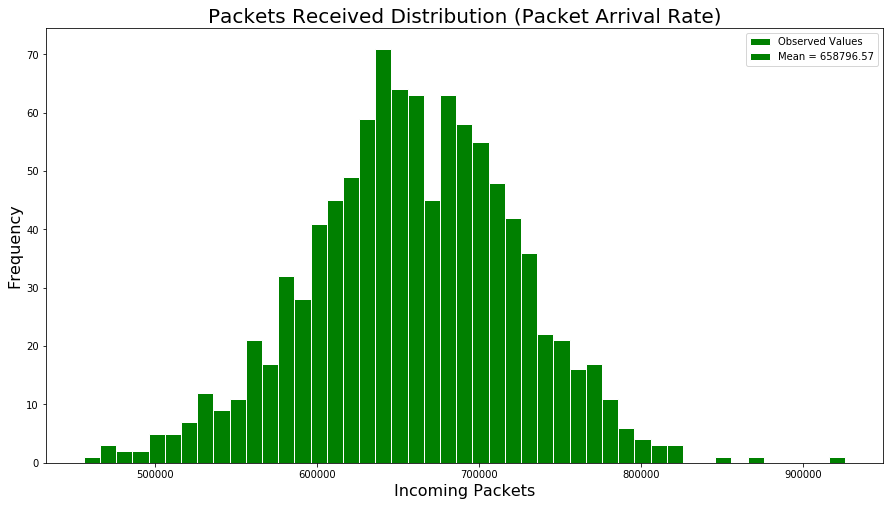

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import style
from decimal import Decimal
import math
import time

size_step = float(input("\nEnter a step value to bin the http response size data: "))

# Newly generated data is read in the following block of code for further processing and plotting 
columns = ['http_response_size']
df = pd.read_csv('final_task_SimCN_FinalTask_2020_traces_TeamA2-3s.csv',delimiter=',', skiprows=[0], names=columns)

print("\n", df, "\n")
y = df['http_response_size']

plt.figure(figsize=(15,8))
plt.title('Packets Received Distribution (Packet Arrival Rate)', size = 20)
plt.xlabel('Incoming Packets', size = 16)
plt.ylabel('Frequency', size = 16)
plt.hist(y, bins = range(int(y.min()), int(y.max())+int(size_step), int(size_step)) , color = 'green', ec = 'white', label = True)
plt.legend(['Observed Values',f"Mean = {y.mean()}"], loc='upper right')


print(f"Minimum packet rate value: {y.min()}")
print(f"Maximum packet rate value: {y.max()}")


# Expected Values


Enter the number of intervals desired for Chi-Square Test: 10
999

Consider entering a new interval that is less than 10 !!!

Enter the number of intervals desired for Chi-Square Test: 9
999

   HTTP Response Size  N_j     np_j  (N_j - np_j)^2/np_j
0   (455845, 506977]   14    8.388                3.755
1   (506977, 558108]   46   49.739                0.281
2   (558108, 609239]  151  161.667                0.704
3   (609239, 660370]  300  288.628                0.448
4   (660370, 711501]  284  283.367                0.001
5   (711501, 762632]  152  152.980                0.006
6   (762632, 813763]   46   45.360                0.009
7   (813763, 864894]    5    7.371                0.763
8   (864894, 916025]    1    0.655                0.182 



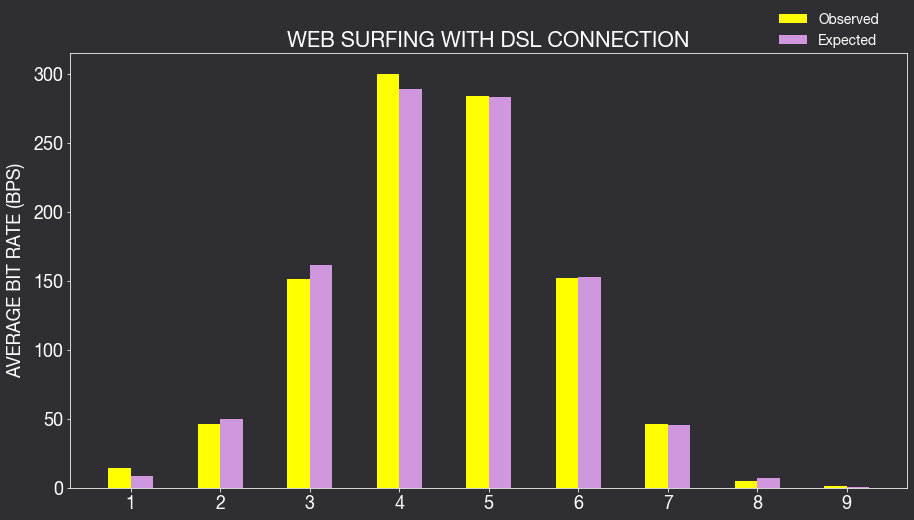

In [43]:
from numpy import savetxt
from scipy.stats import norm
import statistics

np.set_printoptions(suppress=True)

def interval_range():
    interval_range = []
    interval_range.append(obs_min)
    value = obs_min
    for i in range(1, int(k)+1, 1):
        if (value <= obs_max):
            value += interval_size
            interval_range.append(value)
    return interval_range

def np_j_less_than_5(array):
    counter = 0
    for i in array:
        if i < 5.0:
            counter+=1
    return counter

# We are required to generate an expected array with the same mean as the observed array

columns = ['HTTP Response Size']
df = pd.read_csv('final_task_SimCN_FinalTask_2020_traces_TeamA2-3s.csv',delimiter=',', skiprows=[0], names=columns)
y =  df['HTTP Response Size']

run = True
while run:
    try:
        k = float(input("\nEnter the number of intervals desired for Chi-Square Test: ")) #Interval
        
        obs_max = int(y.max())
        obs_min = int(y.min())
        interval_size = int((obs_max - obs_min) / k)

        equi_distant_table = df["HTTP Response Size"].groupby(pd.cut(df["HTTP Response Size"], 
           interval_range(),precision=0, include_lowest=True)).count().to_frame('N_j').reset_index()

        n_pts = equi_distant_table['N_j'].sum() # number of data points (sum of occurrances)
        print(n_pts)
        # Observed occurances of data is saved to csv file
        savetxt('observed_http_response_sizes.csv', equi_distant_table['N_j'], delimiter=',')

        # Here we calculate the pdf for each bin and multiply it by the total count to get expected frequency array
        expected_frequency = []
        for i in range(1, int(k) + 1, 1):
            expected_frequency.append(n_pts * (norm.cdf(obs_min + i * interval_size, loc = statistics.mean(y), scale=statistics.stdev(y)) -
                                                       norm.cdf(obs_min + (i-1) * interval_size, loc = statistics.mean(y), scale=statistics.stdev(y)))) 
            #print(obs_min + i * interval_size)

                
        if (k >= 3 and (min(expected_frequency) >= (5 * np_j_less_than_5(expected_frequency))/int(k))):
            equi_distant_table['np_j'] = np.array(expected_frequency)
            equi_distant_table['(N_j - np_j)^2/np_j'] = ((equi_distant_table['N_j'] - 
                                                          equi_distant_table['np_j'])**2)/equi_distant_table['np_j']

            print("\n", equi_distant_table.round(3),"\n")

            # Expected frequency of data is saved to csv file
            savetxt('expected_http_response_sizes.csv', equi_distant_table['np_j'], delimiter=',')
        else:
            raise Exception
            
    except:
        if (k < 3):
            print(f"\nConsider entering a new interval that is at least 3 !!!")
            run = False
        else:
            print(f"\nConsider entering a new interval that is less than {int(k)} !!!")
            continue 
    else:
        
        # Parameter setting for plotting
        plt.rcParams['axes.edgecolor']='#333F4B'
        plt.rcParams['axes.linewidth']=0.8
        plt.rcParams['xtick.color']='#FFFFFF'
        plt.rcParams['ytick.color']='#FFFFFF'
        plt.rcParams.update({'font.size': 18})
        plt.rcParams["legend.edgecolor"] = 'inherit'
        plt.rcParams["axes.edgecolor"] = 'white'
        plt.rcParams["legend.facecolor"] = 'inherit'
        plt.rcParams["axes.facecolor"] = 'white'
        plt.rcParams["font.family"] = 'serif'
        plt.rcParams['font.serif'] = 'Helvetica Neue'
        
        # And finally plot the cdf
        fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
        ax1.set_facecolor((0.18, 0.18, 0.2)) 
        
        width = 0.25
        #plt.figure(figsize=(15,8))
        x = np.arange(int(k))
        observed = np.array(equi_distant_table['N_j'],dtype=int)
        ax1.bar(x, observed, width, color='yellow', label='Observed')
        ax1.bar(x + width, expected_frequency, width, color='#D097DF', label='Expected')
        
        labels = [str(i+1) for i in x]
        #print(labels)
        x = np.arange(len(labels))  # the label locations
        ax1.set_xticks(x + width/2)
        ax1.set_xticklabels(labels ,color = '#FFFFFF')
        
        #plt.legend(['Observed','Expected'], loc='upper right')
        #array = interval_range()
        #print(array)
        
        ax1.set_ylabel('AVERAGE BIT RATE (BPS)', labelpad=8, color = '#FFFFFF')
        #
        ax1.set_title('WEB SURFING WITH DSL CONNECTION', color = '#FFFFFF')
        #
        leg1 = plt.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.84, 1.0), ncol=1, borderaxespad=0, frameon=False)
                
        for text in leg1.get_texts():
            text.set_color("white")
    
        plt.show()
        run = False
        

460.187


/Users/royruiz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The normed argument is ignored when density is provided. In future passing both will result in an error.


<Figure size 1080x576 with 0 Axes>

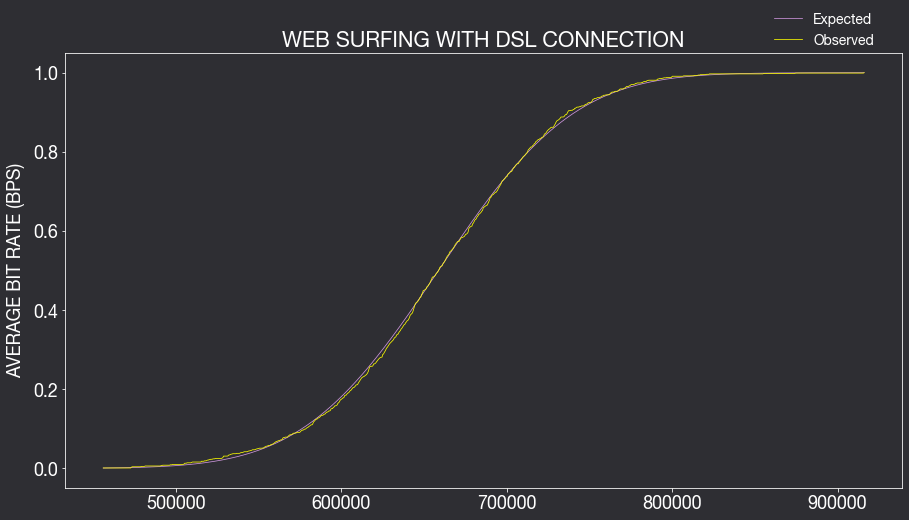

In [44]:
import numpy as np
import matplotlib.pyplot as plt

expected_frequency = []
x = []
plt.figure(figsize=(15,8))
interval_size = (obs_max - obs_min) / 1000
print(interval_size)
for i in range(1, 1001, 1 ):
    expected_frequency.append((norm.cdf(obs_min + i * interval_size, loc = statistics.mean(y), scale=statistics.stdev(y))))
    x.append(obs_min + i * interval_size)

data = np.loadtxt(open('final_task_SimCN_FinalTask_2020_traces_TeamA2-3s.csv'), skiprows=1, delimiter=',')

# Choose how many bins you want here
num_bins = 1000

# Use the histogram function to bin the data
counts, bin_edges = np.histogram(data, bins=num_bins, normed=True, density=False)

# Now find the cdf
cdf = np.cumsum(counts/len(data))

# Parameter setting for plotting
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#FFFFFF'
plt.rcParams['ytick.color']='#FFFFFF'
plt.rcParams.update({'font.size': 18})
plt.rcParams["legend.edgecolor"] = 'inherit'
plt.rcParams["axes.edgecolor"] = 'white'
plt.rcParams["legend.facecolor"] = 'inherit'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica Neue'


# And finally plot the cdf
fig, ax1 = plt.subplots(figsize=(15, 8), facecolor = (0.18, 0.18, 0.2))
ax1.set_facecolor((0.18, 0.18, 0.2)) 

# plt.figure(figsize=(15,8))
ax1.plot(x, expected_frequency, lw=0.75, color='#D097DF',label='Expected')
ax1.plot(bin_edges[1:], cdf, lw=0.75, color='yellow',label='Observed')

ax1.set_ylabel('AVERAGE BIT RATE (BPS)', labelpad=8, color = '#FFFFFF')

ax1.set_title('WEB SURFING WITH DSL CONNECTION', color = '#FFFFFF')

leg1 = plt.legend(fontsize = 14, loc='lower left', bbox_to_anchor= (0.84, 1.0), ncol=1, borderaxespad=0, frameon=False)
        
for text in leg1.get_texts():
    text.set_color("white")

plt.show()

# Chi-Square Test

In [45]:
from scipy.stats import chisquare
from scipy import stats

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

dof = k - 1
crit = stats.chi2.ppf(q=0.95, df=dof) # q here is 1 - alpha, which is 0.05
print(f"Chi-Square Critical Value is {crit}\n---\n")

cols = ['obs']
obs = pd.read_csv('observed_http_response_sizes.csv',delimiter=',', names = cols)
observed_vals = obs['obs']

cols1 = ['exp']
exp = pd.read_csv('expected_http_response_sizes.csv',delimiter=',', names=cols1)
expected_vals = exp['exp']

chisq_sum = equi_distant_table['(N_j - np_j)^2/np_j'].sum()
print(f"Measured Chi-Square Value is {chisq_sum}")

chisq, p = chisquare(observed_vals, f_exp = expected_vals, ddof = 0, axis = 0)
print(f"Chi-Square Value using built-in function is {chisq}")
print(f"P-Value using built-in function is {p}")

if (chisq < crit): print("\nThe null hypothesis, H0, is ACCEPTED!".translate(SUB))
else: print("\nThe null hypothesis, H0, is REJECTED!".translate(SUB))


Chi-Square Critical Value is 15.50731305586545
---

Measured Chi-Square Value is 6.149503289161904
Chi-Square Value using built-in function is 6.149503289161906
P-Value using built-in function is 0.6304895289606174

The null hypothesis, H₀, is ACCEPTED!
